In [1]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import os, shutil
import logging
import warnings

# Hide Python warnings (including Keras save warnings)
warnings.filterwarnings("ignore")

# Hide TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # hide TF logs (INFO/WARNING/ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)

## Import required libraries

In [3]:
import numpy as np
import pandas as pd
import cv2
import skimage.segmentation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [4]:
"""
This function:
1. Reads X-ray images from folders
2. Converts them to grayscale
3. Resizes them to 128×128
4. Assigns numerical labels
5. Returns data ready for CNN training

"""
labels = ['NORMAL','PNEUMONIA']
img_size = 128
def get_data(data_dir):
    X = []  # images
    y = []  # labels

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_arr is None:
                    continue  # skip broken images

                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                X.append(resized_arr)
                y.append(class_num)

            except Exception as e:
                print(e)

    return np.array(X), np.array(y)

## Split the data into train and test

In [5]:
X_train, y_train = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
X_test, y_test = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
X_val, y_val = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/val")

In [6]:
## Shape of the training data
X_train.shape , y_train.shape

((5216, 128, 128), (5216,))

In [7]:
pneumonia = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

## Plotting random images of Pneumonia and Normal Xray images

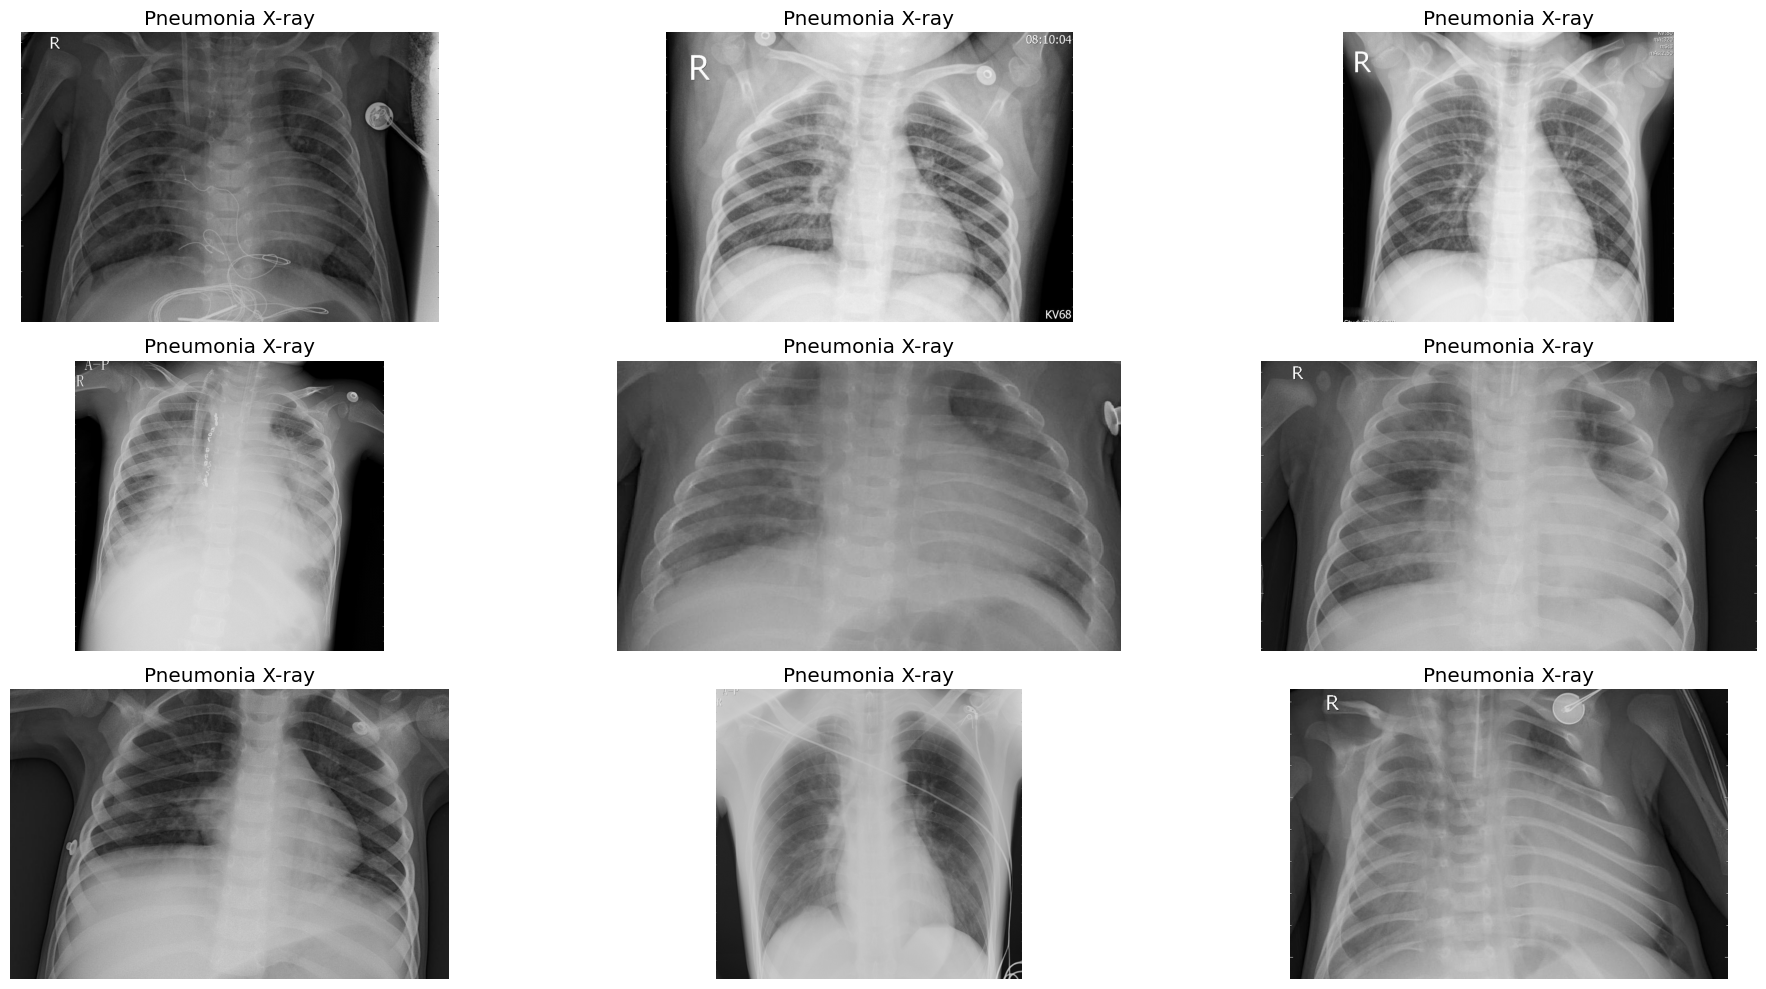

In [8]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir,pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [9]:
normal = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

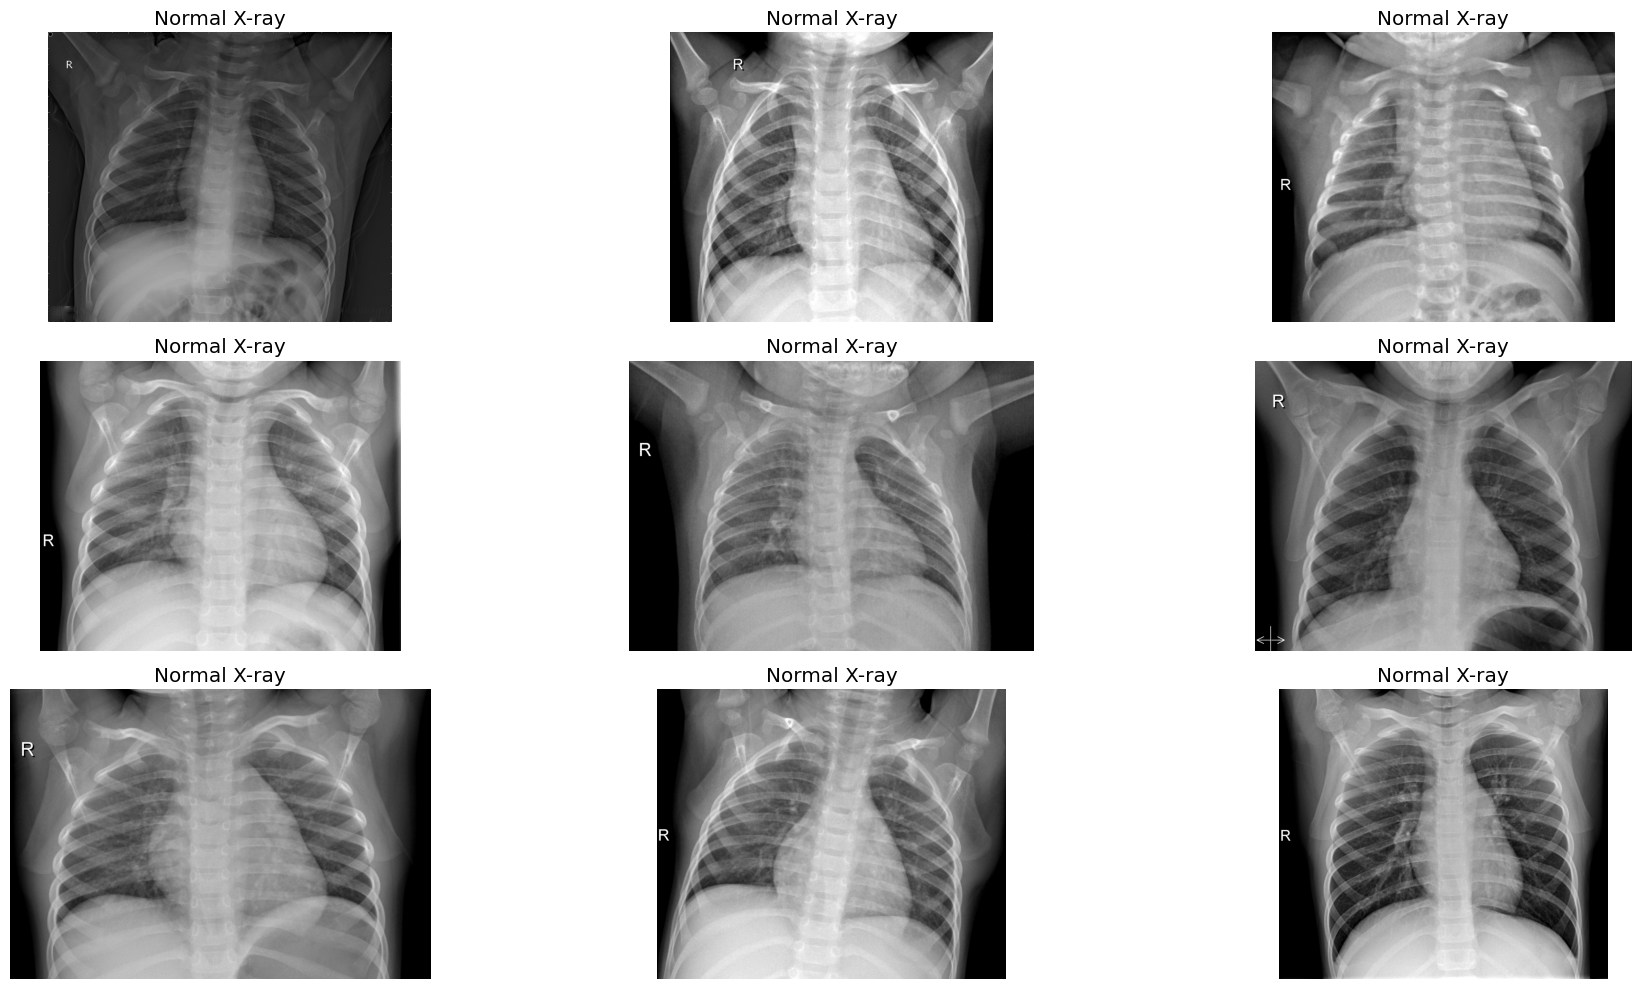

In [10]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_dir,normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

## Distribution of Class labels

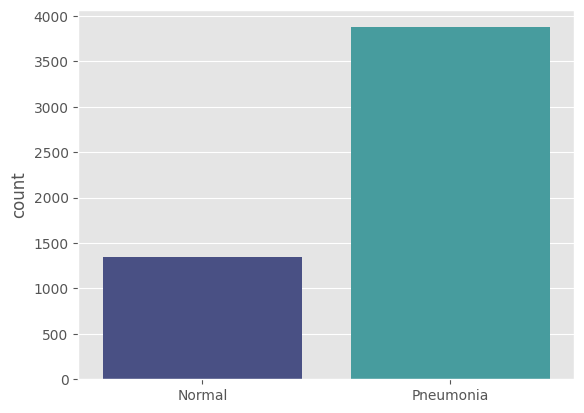

In [11]:
lst = []
for label in y_train:
    if label == 0:
        lst.append("Normal")
    else:
        lst.append("Pneumonia")

sns.countplot(x=lst, palette="mako")
plt.show()

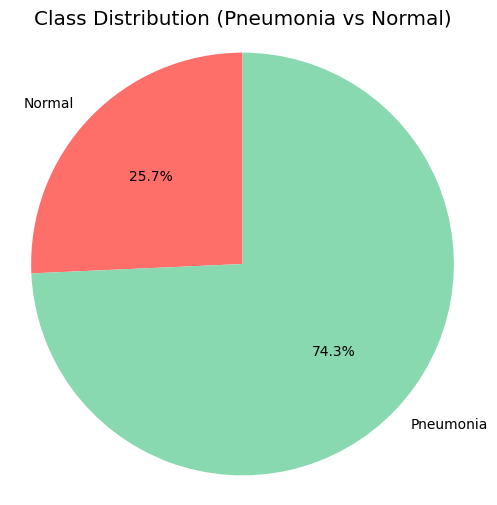

In [12]:
from collections import Counter

# Count classes
counts = Counter(lst)

labels = counts.keys()
sizes = counts.values()

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff6f69', '#88d8b0']
)
plt.title("Class Distribution (Pneumonia vs Normal)")
plt.axis('equal')  # makes the pie chart circular
plt.show()

### Data Augmentation & Resizing

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten,Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

E0000 00:00:1767078903.548597      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767078903.599056      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767078904.038370      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767078904.038391      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767078904.038394      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767078904.038397      24 computation_placer.cc:177] computation placer already registered. Please check linka

## Data Augmentation

In [14]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest"
)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
train_generator = train_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
test_generator = test_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
class_labels = train_generator.class_indices
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [17]:
class_name = {value: key for (key, value) in class_labels.items()}
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

## VGG19 Architechture

In [18]:
# This model uses transfer learning with a pretrained VGG19 network as a frozen feature extractor and
# a custom dense classifier to perform binary pneumonia classification from chest X-rays.

vgg19_base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
## Freeze all th layers of base model
for layer in vgg19_base_model.layers:
    layer.trainable = False

x = vgg19_base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

vgg19_model_01 = Model(vgg19_base_model.inputs, output)
vgg19_model_01.summary()

I0000 00:00:1767078917.138228      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767078917.142147      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
for layer in vgg19_model_01.layers:
    print(layer.name, layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_conv4 False
block5_pool False
flatten True
dense True
dropout True
dense_1 True
dense_2 True


## Model compilation

In [20]:
# Training configuration - How model learns, stops, adjust learning rate, and saves the best version
filepath = "vgg19_best.h5"

earlystopping = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
checkpoint=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, factor=0.5, min_lr=0.0001)
sgd = SGD(learning_rate=1e-4, decay = 1e-6, momentum=0.9, nesterov = True)

vgg19_model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [21]:
history_01 = vgg19_model_01.fit(train_generator,
            steps_per_epoch=50,
            epochs=30,
            callbacks=[earlystopping, checkpoint, lrr],
            validation_data=valid_generator)

Epoch 1/30


I0000 00:00:1767078922.023114      91 service.cc:152] XLA service 0x7c5b340028b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767078922.023149      91 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767078922.023155      91 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767078922.550694      91 cuda_dnn.cc:529] Loaded cuDNN version 91002


 2/50 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5781 - loss: 0.7091

I0000 00:00:1767078929.264092      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 441ms/step - accuracy: 0.7308 - loss: 0.5490 - val_accuracy: 0.6875 - val_loss: 0.5574 - learning_rate: 1.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step - accuracy: 0.8256 - loss: 0.4094 - val_accuracy: 0.6250 - val_loss: 0.5978 - learning_rate: 1.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.8629 - loss: 0.3107 - val_accuracy: 0.8750 - val_loss: 0.4379 - learning_rate: 1.0000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8884 - loss: 0.2968 - val_accuracy: 0.7500 - val_loss: 0.4887 - learning_rate: 1.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.8918 - loss: 0.2726 - val_accuracy: 0.8125 - val_loss: 0.4593 - learning_rate: 1.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.8891 - loss: 0.2713 - val_accuracy: 0.8750 - val_loss: 0.4083 - learning_rate: 1.0000e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 379ms/step - accuracy: 0.9186

In [22]:
# Load the model
from tensorflow.keras.models import load_model

vgg19_model = load_model("vgg19_best.h5")

vgg19_val_eval_01 = vgg19_model.evaluate(valid_generator)
vgg19_test_eval_01 = vgg19_model.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8125 - loss: 0.3342
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8235 - loss: 0.3751


## Model Evaluation

In [23]:
print(f"Validation Loss: {vgg19_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg19_val_eval_01[1]}")
print(f"Test Loss: {vgg19_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg19_test_eval_01[1]}")

Validation Loss: 0.3341723084449768
Validation Accuarcy: 0.8125
Test Loss: 0.3488004803657532
Test Accuarcy: 0.8413461446762085


## Increamental unfreezing & fine tuning

In [24]:
vgg19_base_model_layer_names = [layer.name for layer in vgg19_base_model.layers]
print("Number of layers in the Vgg19 base model: ", len(vgg19_base_model.layers))
print("Last 5 layers: ", vgg19_base_model_layer_names[-5:])
vgg19_base_model_layer_names

Number of layers in the Vgg19 base model:  22
Last 5 layers:  ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


['input_layer',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [25]:
vgg19_base_model = VGG19(
    include_top=False,
    input_shape=(128,128,3),
    weights="imagenet"
)

# Freeze everything
for layer in vgg19_base_model.layers:
    layer.trainable = False

# Unfreeze last 2 conv layers
for layer in vgg19_base_model.layers:
    if layer.name in ['block5_conv3', 'block5_conv4']:
        layer.trainable = True


x = vgg19_base_model.output
flat = Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

Vgg19_model_tuned = Model(vgg19_base_model.input, output)

Vgg19_model_tuned.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 47,784,834 (182.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [26]:
for layer in Vgg19_model_tuned.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_conv4 True
block5_pool False
flatten_1 True
dense_3 True
dropout_1 True
dense_4 True
dense_5 True


In [27]:
earlystopping = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
checkpoint=ModelCheckpoint("vgg19_tuned_best.h5", monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, factor=0.5, min_lr=0.0001)
sgd = SGD(learning_rate=1e-4, decay = 1e-6, momentum=0.9, nesterov = True)

Vgg19_model_tuned.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [28]:
history_02 = Vgg19_model_tuned.fit(train_generator,
            steps_per_epoch=50,
            epochs=30,
            callbacks=[earlystopping, checkpoint, lrr],
            validation_data=valid_generator)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 395ms/step - accuracy: 0.7157 - loss: 0.5490 - val_accuracy: 0.6250 - val_loss: 0.6063 - learning_rate: 1.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.8601 - loss: 0.3338 - val_accuracy: 0.6875 - val_loss: 0.5373 - learning_rate: 1.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - accuracy: 0.8869 - loss: 0.2650 - val_accuracy: 0.8750 - val_loss: 0.4406 - learning_rate: 1.0000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8954 - loss: 0.2753 - val_accuracy: 0.8750 - val_loss: 0.4033 - learning_rate: 1.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.9187 - loss: 0.2092 - val_accuracy: 0.8125 - val_loss: 0.4996 - learning_rate: 1.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.8877 - loss: 0.2420 - val_accuracy: 0.8750 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accur

In [29]:
vgg19_tuned_best_model =load_model("vgg19_tuned_best.h5")

vgg19_val_eval_02 = vgg19_tuned_best_model.evaluate(valid_generator)
vgg19_test_eval_02 = vgg19_tuned_best_model.evaluate(test_generator)

print(f"Validation Loss: {vgg19_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg19_val_eval_02[1]}")
print(f"Test Loss: {vgg19_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg19_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8125 - loss: 0.3365
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.8827 - loss: 0.3328
Validation Loss: 0.33653363585472107
Validation Accuarcy: 0.8125
Test Loss: 0.3221379220485687
Test Accuarcy: 0.8910256624221802


## EfficientNetB3 Model
EfficientNet-B3 applies compound scaling to achieve higher accuracy with fewer parameters, making it more efficient and better suited for medical imaging tasks

In [30]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

In [31]:
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # REQUIRED
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation & Test Generators (NO augmentation)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [32]:
train_generator = train_datagen.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/train",
    target_size=(300, 300),   # REQUIRED for EfficientNet-B3
    batch_size=16,
    class_mode="binary",
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/val",
    target_size=(300, 300),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/test",
    target_size=(300, 300),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [33]:
print(train_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [34]:
x_batch, y_batch = next(train_generator)
print(x_batch.shape, y_batch.shape)

(16, 300, 300, 3) (16,)


In [35]:
EfficientNetB3_base_model = EfficientNetB3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the Base model
for layer in EfficientNetB3_base_model.layers:
    layer.trainable = False

x = EfficientNetB3_base_model.output
x = GlobalAveragePooling2D()(x)   # BETTER than Flatten
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(1, activation="sigmoid")(x)

efficientNetB3_model = Model(inputs=EfficientNetB3_base_model.input, outputs=output)
efficientNetB3_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,570,992 (44.14 MB)

 Trainable params: 787,457 (3.00 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [36]:
print("Number of layers in the EfficientNetB3 base model: ", len(EfficientNetB3_base_model.layers))

Number of layers in the EfficientNetB3 base model:  385


In [37]:
for layer in efficientNetB3_model.layers:
    print(layer.name, layer.trainable)

input_layer_2 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False

In [38]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# Stop when validation loss stops improving
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Save the best model
checkpoint = ModelCheckpoint(
    "efficientnet_b3_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Reduce LR when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [39]:
efficientNetB3_model.compile( optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [40]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

In [41]:
history = efficientNetB3_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8856 - loss: 0.2778
Epoch 1: val_loss improved from inf to 0.15202, saving model to efficientnet_b3_best.h5
326/326 ━━━━━━━━━━━━━━━━━━━━ 173s 410ms/step - accuracy: 0.8857 - loss: 0.2776 - val_accuracy: 1.0000 - val_loss: 0.1520 - learning_rate: 1.0000e-04
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9453 - loss: 0.1386
Epoch 2: val_loss improved from 0.15202 to 0.12316, saving model to efficientnet_b3_best.h5
326/326 ━━━━━━━━━━━━━━━━━━━━ 123s 377ms/step - accuracy: 0.9453 - loss: 0.1385 - val_accuracy: 1.0000 - val_loss: 0.1232 - learning_rate: 1.0000e-04
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9553 - loss: 0.1167
Epoch 3: val_loss improved from 0.12316 to 0.09774, saving model to efficientnet_b3_best.h5
326/326 ━━━━━━━━━━━━━━━━━━━━ 123s 376ms/step - accuracy: 0.9553 - loss: 0.1167 - val_accuracy: 0.9375 - val_loss: 0.0977 - learning_rate: 1.0000e-04
Epoch 4/30
326/32

In [42]:
efficientB3 = load_model("efficientnet_b3_best.h5")

eff_val_eval_01 = efficientB3.evaluate(valid_generator)
eff_test_eval_01 = efficientB3.evaluate(test_generator)

print(f"Validation Loss: {eff_val_eval_01[0]}")
print(f"Validation Accuarcy: {eff_val_eval_01[1]}")
print(f"Test Loss: {eff_test_eval_01[0]}")
print(f"Test Accuarcy: {eff_test_eval_01[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 1.0000 - loss: 0.0489
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7550 - loss: 0.6417
Validation Loss: 0.04891795665025711
Validation Accuarcy: 1.0
Test Loss: 0.38279271125793457
Test Accuarcy: 0.8557692170143127


## Incremental unfreezing and Fine tunning

In [43]:
EfficientNetB3_base_model = EfficientNetB3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet"
)

# Unfreeze top layers of EfficientNet
for layer in EfficientNetB3_base_model.layers[-40:]:
    layer.trainable = True

x = EfficientNetB3_base_model.output
x = GlobalAveragePooling2D()(x)   # BETTER than Flatten
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(1, activation="sigmoid")(x)

model_efficientNet_tuned = Model(inputs=EfficientNetB3_base_model.input, outputs=output)
model_efficientNet_tuned.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 300, 300,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,570,992 (44.14 MB)

 Trainable params: 11,483,689 (43.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [44]:
print("Number of layers in the EfficientNetB3 base model: ", len(model_efficientNet_tuned.layers))

Number of layers in the EfficientNetB3 base model:  389


In [45]:
for layer in model_efficientNet_tuned.layers:
    print(layer.name, layer.trainable)

input_layer_3 True
rescaling_2 True
normalization_1 True
rescaling_3 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block1b_dwconv True
block1b_bn True
block1b_activation True
block1b_se_squeeze True
block1b_se_reshape True
block1b_se_reduce True
block1b_se_expand True
block1b_se_excite True
block1b_project_conv True
block1b_project_bn True
block1b_drop True
block1b_add True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand

In [46]:
model_efficientNet_tuned.compile( optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [47]:
history_tuned = model_efficientNet_tuned.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9210 - loss: 0.2063
Epoch 1: val_loss did not improve from 0.04892
326/326 ━━━━━━━━━━━━━━━━━━━━ 252s 437ms/step - accuracy: 0.9211 - loss: 0.2060 - val_accuracy: 0.9375 - val_loss: 0.1168 - learning_rate: 1.0000e-04
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9774 - loss: 0.0617
Epoch 2: val_loss did not improve from 0.04892
326/326 ━━━━━━━━━━━━━━━━━━━━ 132s 403ms/step - accuracy: 0.9774 - loss: 0.0617 - val_accuracy: 0.9375 - val_loss: 0.1234 - learning_rate: 1.0000e-04
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9879 - loss: 0.0382
Epoch 3: val_loss improved from 0.04892 to 0.02323, saving model to efficientnet_b3_best.h5
326/326 ━━━━━━━━━━━━━━━━━━━━ 133s 406ms/step - accuracy: 0.9879 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 0.0232 - learning_rate: 1.0000e-04
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9906 - loss: 0.0266
Epoch 4: val_lo

## Model Evaluation

In [48]:
eff_tuned_val_score = model_efficientNet_tuned.evaluate(valid_generator)
eff_tuned_test_score = model_efficientNet_tuned.evaluate(test_generator)

print(f"Validation Loss: {eff_tuned_val_score[0]}")
print(f"Validation Accuracy: {eff_tuned_val_score[1]}")
print(f"Test Loss: {eff_tuned_test_score[0]}")
print(f"Test Accuracy: {eff_tuned_test_score[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 1.0000 - loss: 5.5300e-04
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8711 - loss: 0.6078
Validation Loss: 0.0005530047928914428
Validation Accuracy: 1.0
Test Loss: 0.39168065786361694
Test Accuracy: 0.9182692170143127


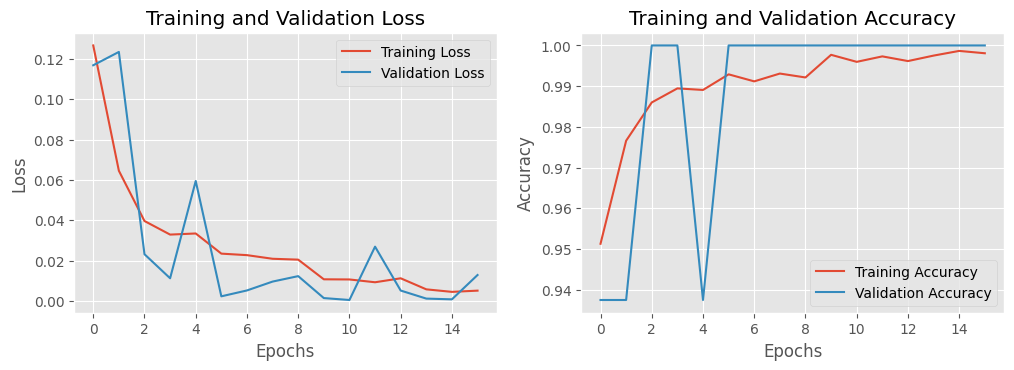

In [49]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(history_tuned.history['loss'], label='Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

## Saving the best model

In [50]:
if not os.path.isdir('saved_model/'):
    os.mkdir("saved_model/")
model_efficientNet_tuned.save(filepath = "saved_model/efficientNet_model_tuned.h5", overwrite=True)

### After tunning on EfficientNetB3 model, we got accuracy on test data ~92%. So we've selected EfficientNetB3 model (Tuned version). Let's see few performance metrics of this model

## Loading the final  model

In [51]:
final_model = tf.keras.models.load_model("saved_model/efficientNet_model_tuned.h5")


In [52]:
# Get true labels from generator
y_true = test_generator.classes

## Final model prediction

In [53]:
# Get model prediction

# Predict probabilities
y_pred_prob = final_model.predict(test_generator)

# Convert probabilities → class labels (0 / 1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)


39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step


In [54]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)

## Plotting Confusion Matrix

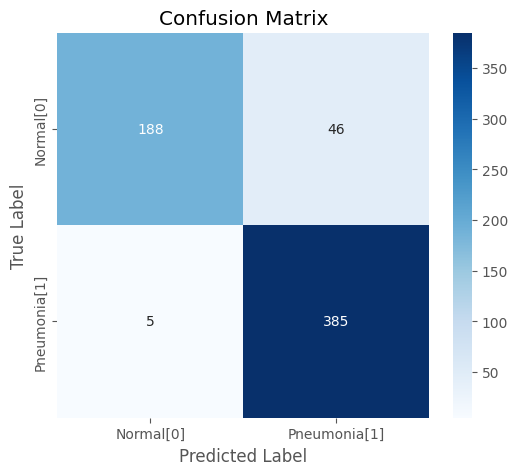

In [55]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal[0]", "Pneumonia[1]"],
    yticklabels=["Normal[0]", "Pneumonia[1]"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Classification Report

In [56]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Normal", "Pneumonia"]
    )
)

              precision    recall  f1-score   support

      Normal       0.97      0.80      0.88       234
   Pneumonia       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



In [57]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("ROC-AUC:", auc)

F1-Score: 0.9378806333739342
Precision: 0.8932714617169374
Recall: 0.9871794871794872
ROC-AUC: 0.9770436116589963


In [58]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

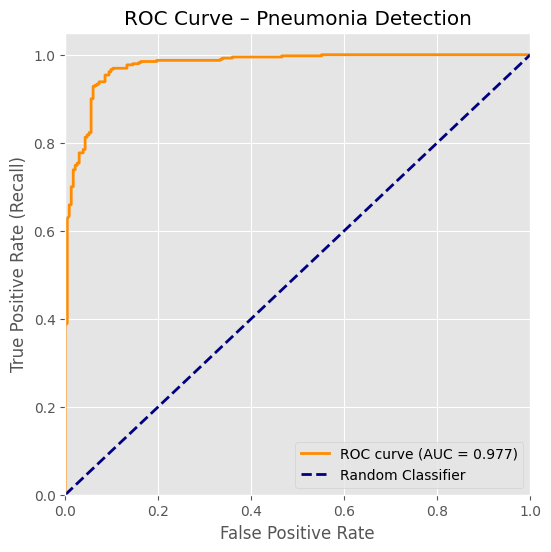

In [59]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc_value:.3f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",
         label="Random Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Pneumonia Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

After fine-tuning the model, I evaluated performance using a confusion matrix and classification report to analyze false negatives, recall, and F1-score, which are critical metrics for medical diagnosis tasks

## Prediction System

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 300  # EfficientNetB3 default input size is 300x300

def predict_pneumonia_xray(img_path):
    """
    Predict pneumonia from chest X-ray image using EfficientNetB3 model.

    Args:
        img_path (str): Path to X-ray image

    Returns:
        dict: {"prediction": "PNEUMONIA/NORMAL", "probability": float}
    """

    # Load image & convert to RGB because EfficientNet expects 3 channels
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)

    # Scale & preprocess (required for EfficientNet)
    img_array = preprocess_input(img_array)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = final_model.predict(img_array)
    pred_prob = final_model.predict(img_array)[0][0]

    # Convert probability to label
    label = "PNEUMONIA" if pred_prob >= 0.5 else "NORMAL"
    print(f"Pneumonia Probability: {pred_prob*100:.2f}%")
    print(pred)

    return {
        "prediction": label,
        "probability": float(pred_prob)
    }

## Inference

In [61]:
result = predict_pneumonia_xray("/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg")
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Pneumonia Probability: 100.00%
[[1.]]
{'prediction': 'PNEUMONIA', 'probability': 1.0}


In [62]:
result = predict_pneumonia_xray("/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0005-0001.jpeg")
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Pneumonia Probability: 0.02%
[[0.00019902]]
{'prediction': 'NORMAL', 'probability': 0.00019902081112377346}


In [63]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)

NumPy version: 2.0.2
Pandas version: 2.2.2
TensorFlow version: 2.19.0
